# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from CMEP import CMEP_Atom
from qsps import QSP_HNC
from constants import *
# from hnc_Ng import  HNC_solver
# from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Ha_to_J = 4.359744e-18
k_B = 1.380649e-23 
m_p = 1.672621898e-27 # kg
eV_to_K = 11604.5250061598
J_to_erg = 1e7
Ha_to_erg = Ha_to_J*J_to_erg

# Function that sets up HNC QSP 

## Load TCCW Cases

In [2]:
element='Be1'

if element=='Be1':
    ni_cc = 1.24e23
    Te_eV = 12
    Ti_eV = Te_eV
    Z, A = 4, 9
    Zbar = 2.105
elif element=='Be2':
    ni_cc = 3.67e23
    Te_eV = 13
    Ti_eV = Te_eV
    Z, A = 4, 9
    Zbar = 2.21
elif element=='Be3':
    ni_cc = 3.67e23
    Te_eV = 2
    Ti_eV = Te_eV
    Z, A = 4, 9
    Zbar = 2.21
# elif element='Al1':
#     ni_cc = 6.03e22
#     Te_eV = 1
#     Ti_eV = 1
#     Z, A= 13,
    

ni_AU = ni_cc*1e6*aB**3

r_s_AU = QSP_HNC.rs_from_n(ni_AU)
r_c = 0
if r_c>1:
    r_c=1e-5
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc".format(Te_eV, ni_cc))
print("Te = {0:.3e} K, ρ = {1:.3e} [g/cc] ".format(Te_eV*eV_to_K, 1e3*ni_cc*m_p*A ))
print("r_s = {0:.3f}, r_c/r_s = {1:.3f}".format(r_s_AU, r_c))

Te = 1.200e+01 eV, n_i = 1.240e+23 1/cc
Te = 1.393e+05 K, ρ = 1.867e+00 [g/cc] 
r_s = 2.351, r_c/r_s = 0.000


In [3]:
atom = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options= {'r_c':0.0},
             hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500,'oz_method':'svt'},
             hnc_solve_options={'alpha_Picard':1})
atom.run_hnc()

atom_oz = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar,
             βu_options = {'add_bridge':False,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options= {'r_c':0.0,'which_Tij':'thermal'},
             hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500,'oz_method':'standard'},
             hnc_solve_options={'alpha_Picard':1})
atom_oz.run_hnc()
atom_oz.run_onlyion_hnc()

Te_in_eV: 12.000
Ti_in_eV: 12.000
0: Initial condition Total Error: 3.414e+00
Exiting status 0, reverting to best index so far: 66
Final iter:68, Total Error: 9.180e-09
Te_in_eV: 12.000
Ti_in_eV: 12.000
0: Initial condition Total Error: 3.318e+00
Exiting status 0, reverting to best index so far: 39
Final iter:41, Total Error: 9.748e-09
0: Initial condition Total Error: 3.950e+00
Exiting status 0, reverting to best index so far: 27
Final iter:29, Total Error: 9.055e-09


In [4]:
Bredow_CHNC = read_csv("/home/zach/plasma/datasets/RDFs/Be_12eV_1.24e23cc_CHNC_Bredow.txt", delim_whitespace=True, header=0)
Bredow_DFT = read_csv("/home/zach/plasma/datasets/RDFs/Be_12eV_1.24e23cc_DFT_Bredow.txt", delim_whitespace=True, header=0)
# Bredow_CHNC = read_csv("/home/zach/plasma/datasets/RDFs/Be_13eV_3.676e23cc_CHNC_Bredow.txt", delim_whitespace=True, header=0)
# Bredow_DFT = read_csv("/home/zach/plasma/datasets/RDFs/Be_13eV_3.676e23cc_DFT_Bredow.txt", delim_whitespace=True, header=0)

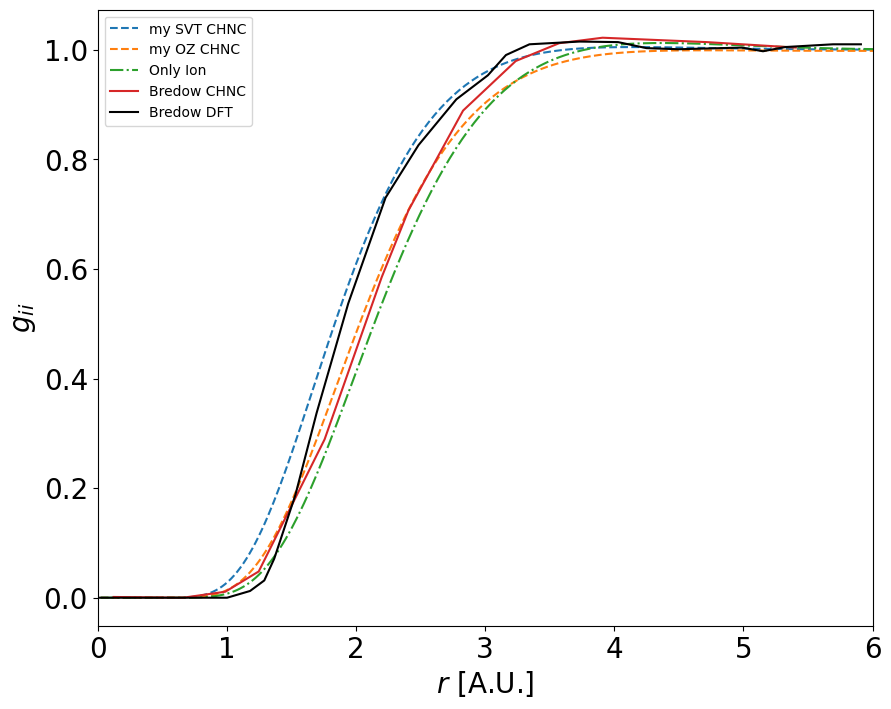

In [5]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.h_r_matrix[0,0]+1,'--', label='my SVT CHNC')
ax.plot(atom_oz.hnc.r_array*atom_oz.qsp.ri, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='my OZ CHNC')
ax.plot(atom_oz.onlyion_hnc.r_array*atom_oz.qsp.ri, atom_oz.onlyion_hnc.h_r_matrix[0,0]+1,'-.', label='Only Ion')

ax.plot(Bredow_CHNC['r[aB]'], Bredow_CHNC['gii'], label="Bredow CHNC")
ax.plot(Bredow_DFT['r[aB]'], Bredow_DFT['gii'],'k-', label="Bredow DFT")
ax.set_xlim(0,6)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r$ [A.U.]',fontsize=20)
ax.tick_params(labelsize=20)

ax.legend()